In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
from sympy import Matrix
from scipy.integrate import solve_ivp
from arc.alkali_atom_functions import AlkaliAtom
import arc
import qutip as qtp

In [12]:
def sigma(a, b): # |a><b| operator
    basis_a = [
        np.array([[1],[0],[0]]),
        np.array([[0],[1],[0]]),
        np.array([[0],[0],[1]])
    ]
    basis_b = [
        np.array([1,0,0]),
        np.array([0,1,0]),
        np.array([0,0,1])
    ]
    return np.kron(basis_a[a],basis_b[b])

def H_0(Omega_b, Omega_IR, Delta, delta):
    dressed_H = np.array([[0, Omega_b/2, 0],[Omega_b/2, -Delta, Omega_IR/2],[0, Omega_IR/2, -delta]])
    return dressed_H

In [37]:
t = 10
steps = 1000
times = np.linspace(0.0, t, steps)
psi0 = qtp.Qobj(np.kron(sigma(0,0), sigma(0,0)))
N_states = 3
N_atoms_in_interaction_volume = 1000

Delta = 300
delta = 0
Om_b = 30 #np.sqrt(two_ph_r_f*2*Delta) #O5s_6p/(2*np.pi)*10**-6 # 10
Om_IR = 4 #np.sqrt(two_ph_r_f*2*Delta) #5 #O6p_70s/(2*np.pi)*10**-6 # 3
two_photon_rabi = (Om_b * Om_IR)/(2*np.pi*Delta)
print(two_photon_rabi*1000, "kHz")
V_f = 0
Gamma_6p = 8
Gamma_70s = 0.01 # 0 # 0.02
def_6p = 4
def_70s = 4

S_minus_6p = Gamma_6p**(1/2)*np.array([[0,1,0],[0,0,0],[0,0,0]])
S_minus_70s = Gamma_70s**(1/2)*np.array([[0,0,0],[0,0,1],[0,0,0]])
Jump_ops = [
    qtp.Qobj(np.kron(S_minus_6p, np.eye(3))), 
    qtp.Qobj(np.kron(np.eye(3), S_minus_6p)), 
    qtp.Qobj(np.kron(S_minus_70s, np.eye(3))), 
    qtp.Qobj(np.kron(np.eye(3), S_minus_70s)),
    qtp.Qobj(np.kron(def_6p * sigma(1,1), np.eye(3))),
    qtp.Qobj(np.kron(np.eye(3), def_6p * sigma(1,1))),
    qtp.Qobj(np.kron(def_70s * sigma(2,2), np.eye(3))),
    qtp.Qobj(np.kron(np.eye(3), def_70s * sigma(2,2))),
    ]

H = qtp.Qobj(np.kron(H_0(Om_b, Om_IR, Delta, 0), np.eye(3)) + np.kron(np.eye(3), H_0(Om_b, Om_IR, Delta, delta)))

63.66197723675813 kHz


In [38]:
result = qtp.mesolve(H, psi0, times, c_ops = Jump_ops)

In [39]:
evo = [np.array(result.states[i]) for i in range(steps)]
p_trace_res = {}
labels = ["ground","intermediate","rydberg"]
for l, label in enumerate(labels):
    p_trace_res[label] = [N_atoms_in_interaction_volume * np.trace(np.dot(evo[i],np.kron(np.eye(3),sigma(l,l)))) for i in range(steps)]

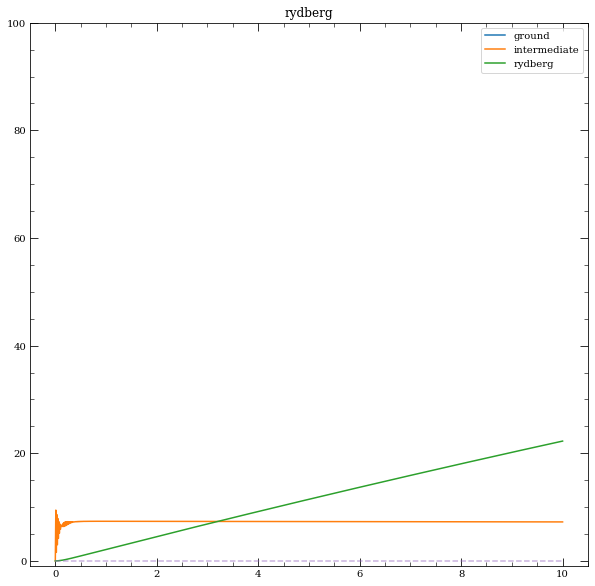

In [40]:
plt.figure(figsize=(10,10))

for i, label in enumerate(labels):
    plt.plot(times, p_trace_res[label], label=label)
plt.plot([0,times[-1]],[N_atoms_in_interaction_volume,N_atoms_in_interaction_volume],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[N_atoms_in_interaction_volume/2,N_atoms_in_interaction_volume/2],"--", alpha=0.5)
plt.ylim([-1,100])
plt.title(label)
plt.legend()

plt.show()

In [41]:
N_points = 50
deltas = np.linspace(-30,30,N_points)
psi0 = qtp.Qobj(sigma(0,0))
Jump_ops = [
    qtp.Qobj(S_minus_6p), 
    qtp.Qobj(S_minus_70s),
    qtp.Qobj(def_6p * sigma(1,1)),
    qtp.Qobj(def_70s * sigma(2,2)),
    ]
results = []
for delta in deltas:
    H = qtp.Qobj(H_0(Om_b, Om_IR, Delta, delta))#, np.eye(3)) + np.kron(np.eye(3), H_0(Om_b, Om_IR, Delta, delta))) #+ H_int(V_f)
    result = qtp.mesolve(H, psi0, times, c_ops = Jump_ops)
    results.append(result.states[-1])

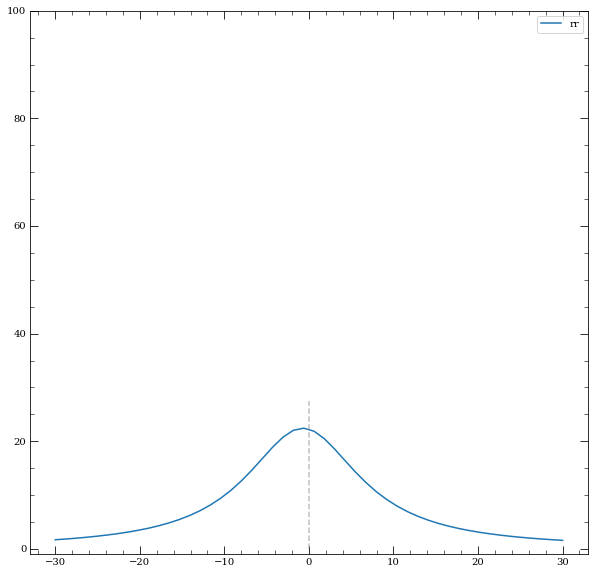

In [42]:
rho_33 = [N_atoms_in_interaction_volume * results[i][2,2] for i in range(N_points)]
#rho_22 = [results[i][1,1] for i in range(N_points)]
plt.figure(figsize=(10,10))
plt.plot(deltas, rho_33, label = "rr")
#plt.plot(deltas, rho_22, label = "rr")
plt.plot([0,0],[0,max(rho_33)+5], "--", c="gray", alpha=0.5)
plt.legend()
plt.ylim([-1,100])
plt.show()